#AB test Knowledge#

## What we want to know vs. what we can do? ##

As game developers, we are interested in understanding how product changes impact Key Performance Indicators (KPIs) for both current and future players. Our main goal is to confidently attribute observed KPI changes to the changes in the game, and not to random sampling error.

For example, if we observe a KPI increase of 33%, we would want to be sure that this increase is not simply due to chance, but rather that the product changes implemented were the true cause. To make this assertion confidently, the observed KPI change should be substantially larger, or more widely distributed across players, than what would be expected from sampling error alone.

## How can we do it? ##

To differentiate between "signal" (i.e., the real effect of the change) and "noise" (i.e., the random variations in the data), we need to perform statistical significance testing.

Normality Check: First, we test for normality in the data using tools like the Shapiro-Wilk test.

Variance Homogeneity Check: We then check if the variances are equal across groups using tests like Levene's test.
Once the data passes these assumptions, we can proceed with either:

Parametric Tests: If the data is normal and variances are equal, we can use t-tests or ANOVA to compare groups.

Non-Parametric Tests: If the data does not meet the assumptions of parametric tests, we can use non-parametric alternatives like the Mann-Whitney U test.

Non-parametric tests do not rely on distribution assumptions and are more flexible when dealing with skewed data.distribution to meet the assumpetion standarads.

## How to understand the test-statistic? ##

The test statistic (t) represents the ratio of signal to noise:

Signal: The difference in KPIs between the two groups being compared.

Noise: The variance, or random variation in KPIs among players in the sample.

$$
t = \frac{\text{Signal}}{\text{Noise}} = \frac{\mu_A - \mu_B}{\sqrt{\frac{S_A^2}{n_A} + \frac{S_B^2}{n_B}}}
$$



## How to change t-statatistic to a p-value? ##

The t-distribution changes with the sample size and becomes narrower and taller as the sample size increases. For larger samples (e.g., in the thousands), this change is less noticeable. The absolute value of the t-statistic in a two-tailed test reflects the strength of evidence against the null hypothesis.

P-value: The p-value represents the probability of observing a t-value as extreme as the one computed, assuming the null hypothesis is true. A smaller p-value suggests stronger evidence against the null hypothesis.

For example, a p-value of 12% suggests that, assuming no true effect, there is a 12% chance of observing such a large KPI increase purely due to sampling error.



## How to draw a conclusion? ##

What p = 12% tells us: If our product changes have no true impact on KPIs, we still have a 12% chance of observing an increase of this magnitude just by chance.

Interpreting the p-value: A p-value of 12% means that if we repeated this experiment 100 times (with similar sample sizes and treatment conditions), we would expect to get a t-value of 1.55 or higher 12 times purely due to random chance.

## Comprehensive Decision-Making ##

In practice, while the p-value is informative, it is not enough to make a decision. Additional factors must be considered:

1.   Technical Risk: How risky is it that bugs or errors will be introduced during rollout?

2.   Player Sentiment Risk: How might players react to these changes? Will they be upset by the change?

3.   New vs. Existing Users: Does the change affect new users differently than existing players? Do we need to test for each group?

4.   Probability Distribution of Effect Size: What effect size do we expect, and is it large enough to justify the risks?

5.   Assessing Prior Experience: Have similar changes been tested before? How did they perform? How confident are we that the competitors' results are applicable to our players?

## Limitations of p-value? ##

One limitation of the p-value is that it does not provide information about the magnitude of the effect. For example, if we observe a 33% ARPU increase with a p-value of 5%, it suggests that the observed change is statistically significant, but it does not give us a concrete idea of how large or reliable the effect is across the entire population.

Thus, a p-value of 5% helps confirm that a larger ARPU increase is likely, but it doesn't provide specific expectations about the magnitude of that lift across all players.



## Power of effect size? ##

Effect size is a measure of the magnitude of the difference between two groups. It is calculated as:

$$
\text{Effect Size} = \frac{\mu_A - \mu_B}{\sqrt{\frac{S_A^2 + S_B^2}{2}}}
$$

The effect and effect size range:

0 - trivial - 0.1 - small - 0.3 - modderate - 0.5 - large

## Sample size? ##

The sample size formula for a two-sample t-test is:

$$
n = \frac{(Z_{\alpha/2} + Z_{\beta})^2 \times (2 \times \sigma^2)}{\Delta^2}
$$

where:
- $\ n$ = required sample size per group
- $Z_{\alpha/2}$ = Z-score for the significance level (1.96 for \( $\alpha$ = 0.05 \))
- $Z_{\beta}$ = Z-score for the power level (0.84 for 80% power)
- $\sigma$ = standard deviation (estimated or from pilot data)
- $\Delta$ = minimum detectable effect size (difference in means between groups)


## Power level? ##

An appropriate level of statistical power is usually considered to be 0.80 or 80%, which means there is an 80% chance of correctly rejecting a false null hypothesis (i.e., detecting an effect if there is one). This threshold helps researchers balance the likelihood of Type II errors (failing to detect a true effect) with practical considerations like sample size and study cost.

An underpowered test = inadequate sample size, which increases the likelihood of geeting false positive or false negative results.

An overpowered test = get much more than sufficient sample size. When the statistical power is 80%, there's 20% having type 2 error, 80% having type 1 error (finding something that's not true is more serious, hence only giving 20%). This also gives burden on data collection process.





## Minimum detectable effect? (MDE) ##

The smallest amount of change that you want to detect.

# Real data project #


## clearning ##

In [72]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats

In [89]:
path = "/content/cookie_cats.csv"

df = pd.read_csv(path)
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [90]:
# check for null values -> quality is good
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [91]:
# data distribution -> same mean, but different std
group_stats = df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

# Calculate summary stats for all data (without grouping)
total_stats = df["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"]).to_frame().T
total_stats.index = ["all_data"]  # Name the index row

# Append the all_data row to the group_stats DataFrame
result = pd.concat([group_stats, total_stats])

# Display the result
print(result)

            count  median       mean         std      max
gate_30   44700.0    17.0  52.456264  256.716423  49854.0
gate_40   45489.0    16.0  51.298776  103.294416   2640.0
all_data  90189.0    16.0  51.872457  195.050858  49854.0


Text(0.5, 1.0, 'Distribution of Two Groups')

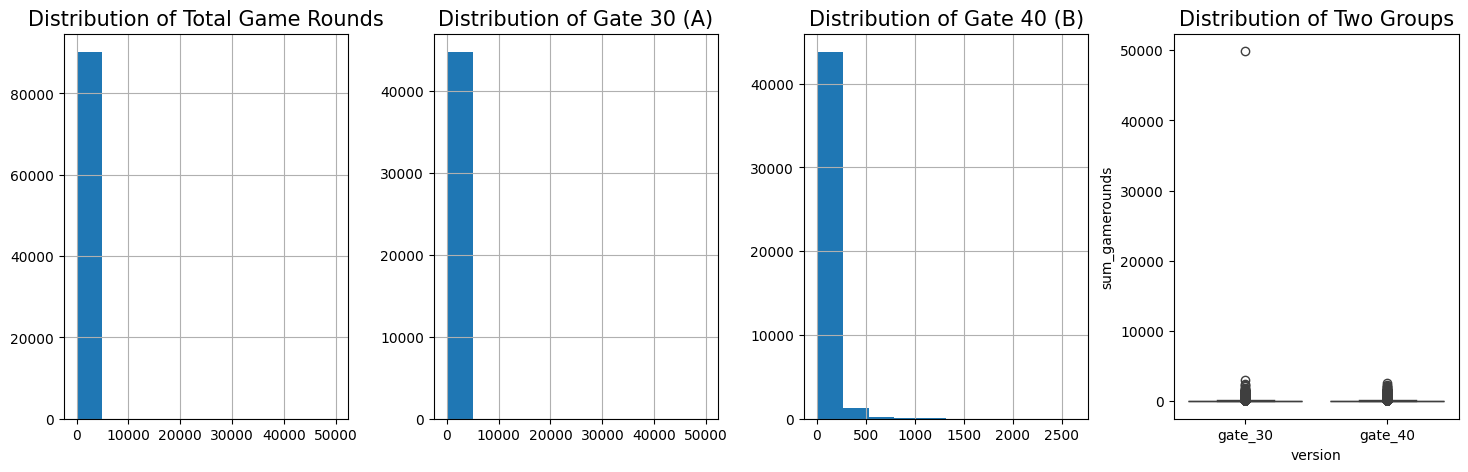

In [92]:
# visual -> there's an outlier
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df.sum_gamerounds.hist(ax = axes[0])
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[1])
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[2])
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])

axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

In [93]:
# remove an outlier
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

Text(0.5, 0.98, 'After Removing The Extreme Value')

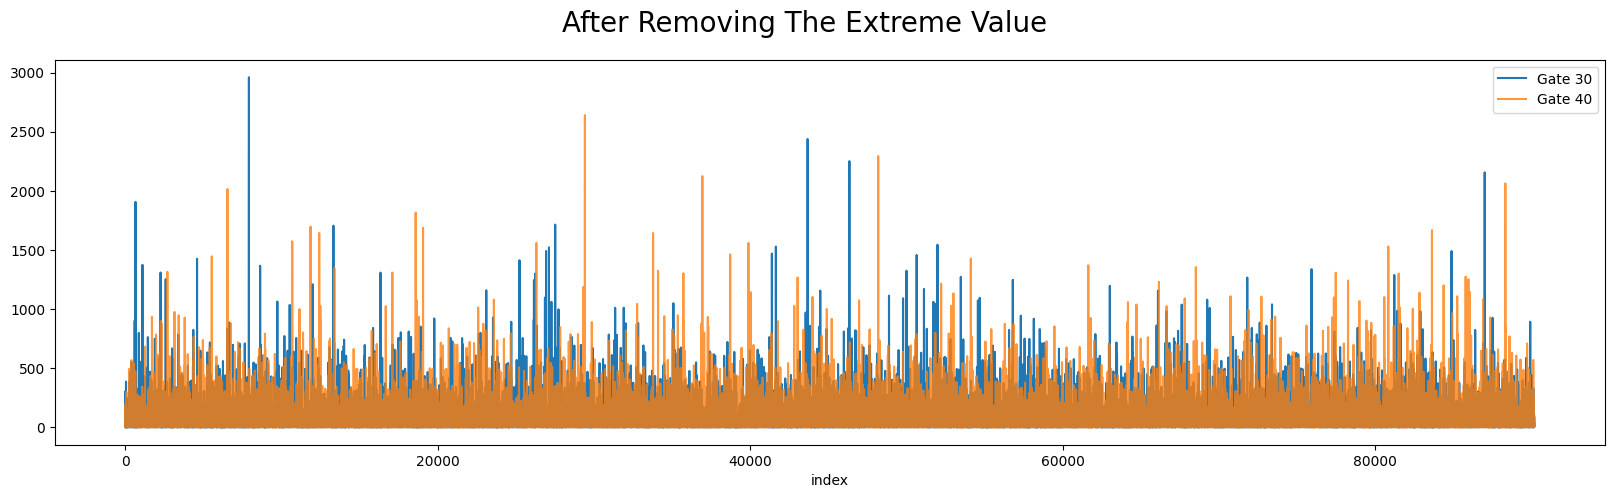

In [94]:
# visual -> seems good to go
df[(df.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(
    legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(
    legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20)

## exploration ##

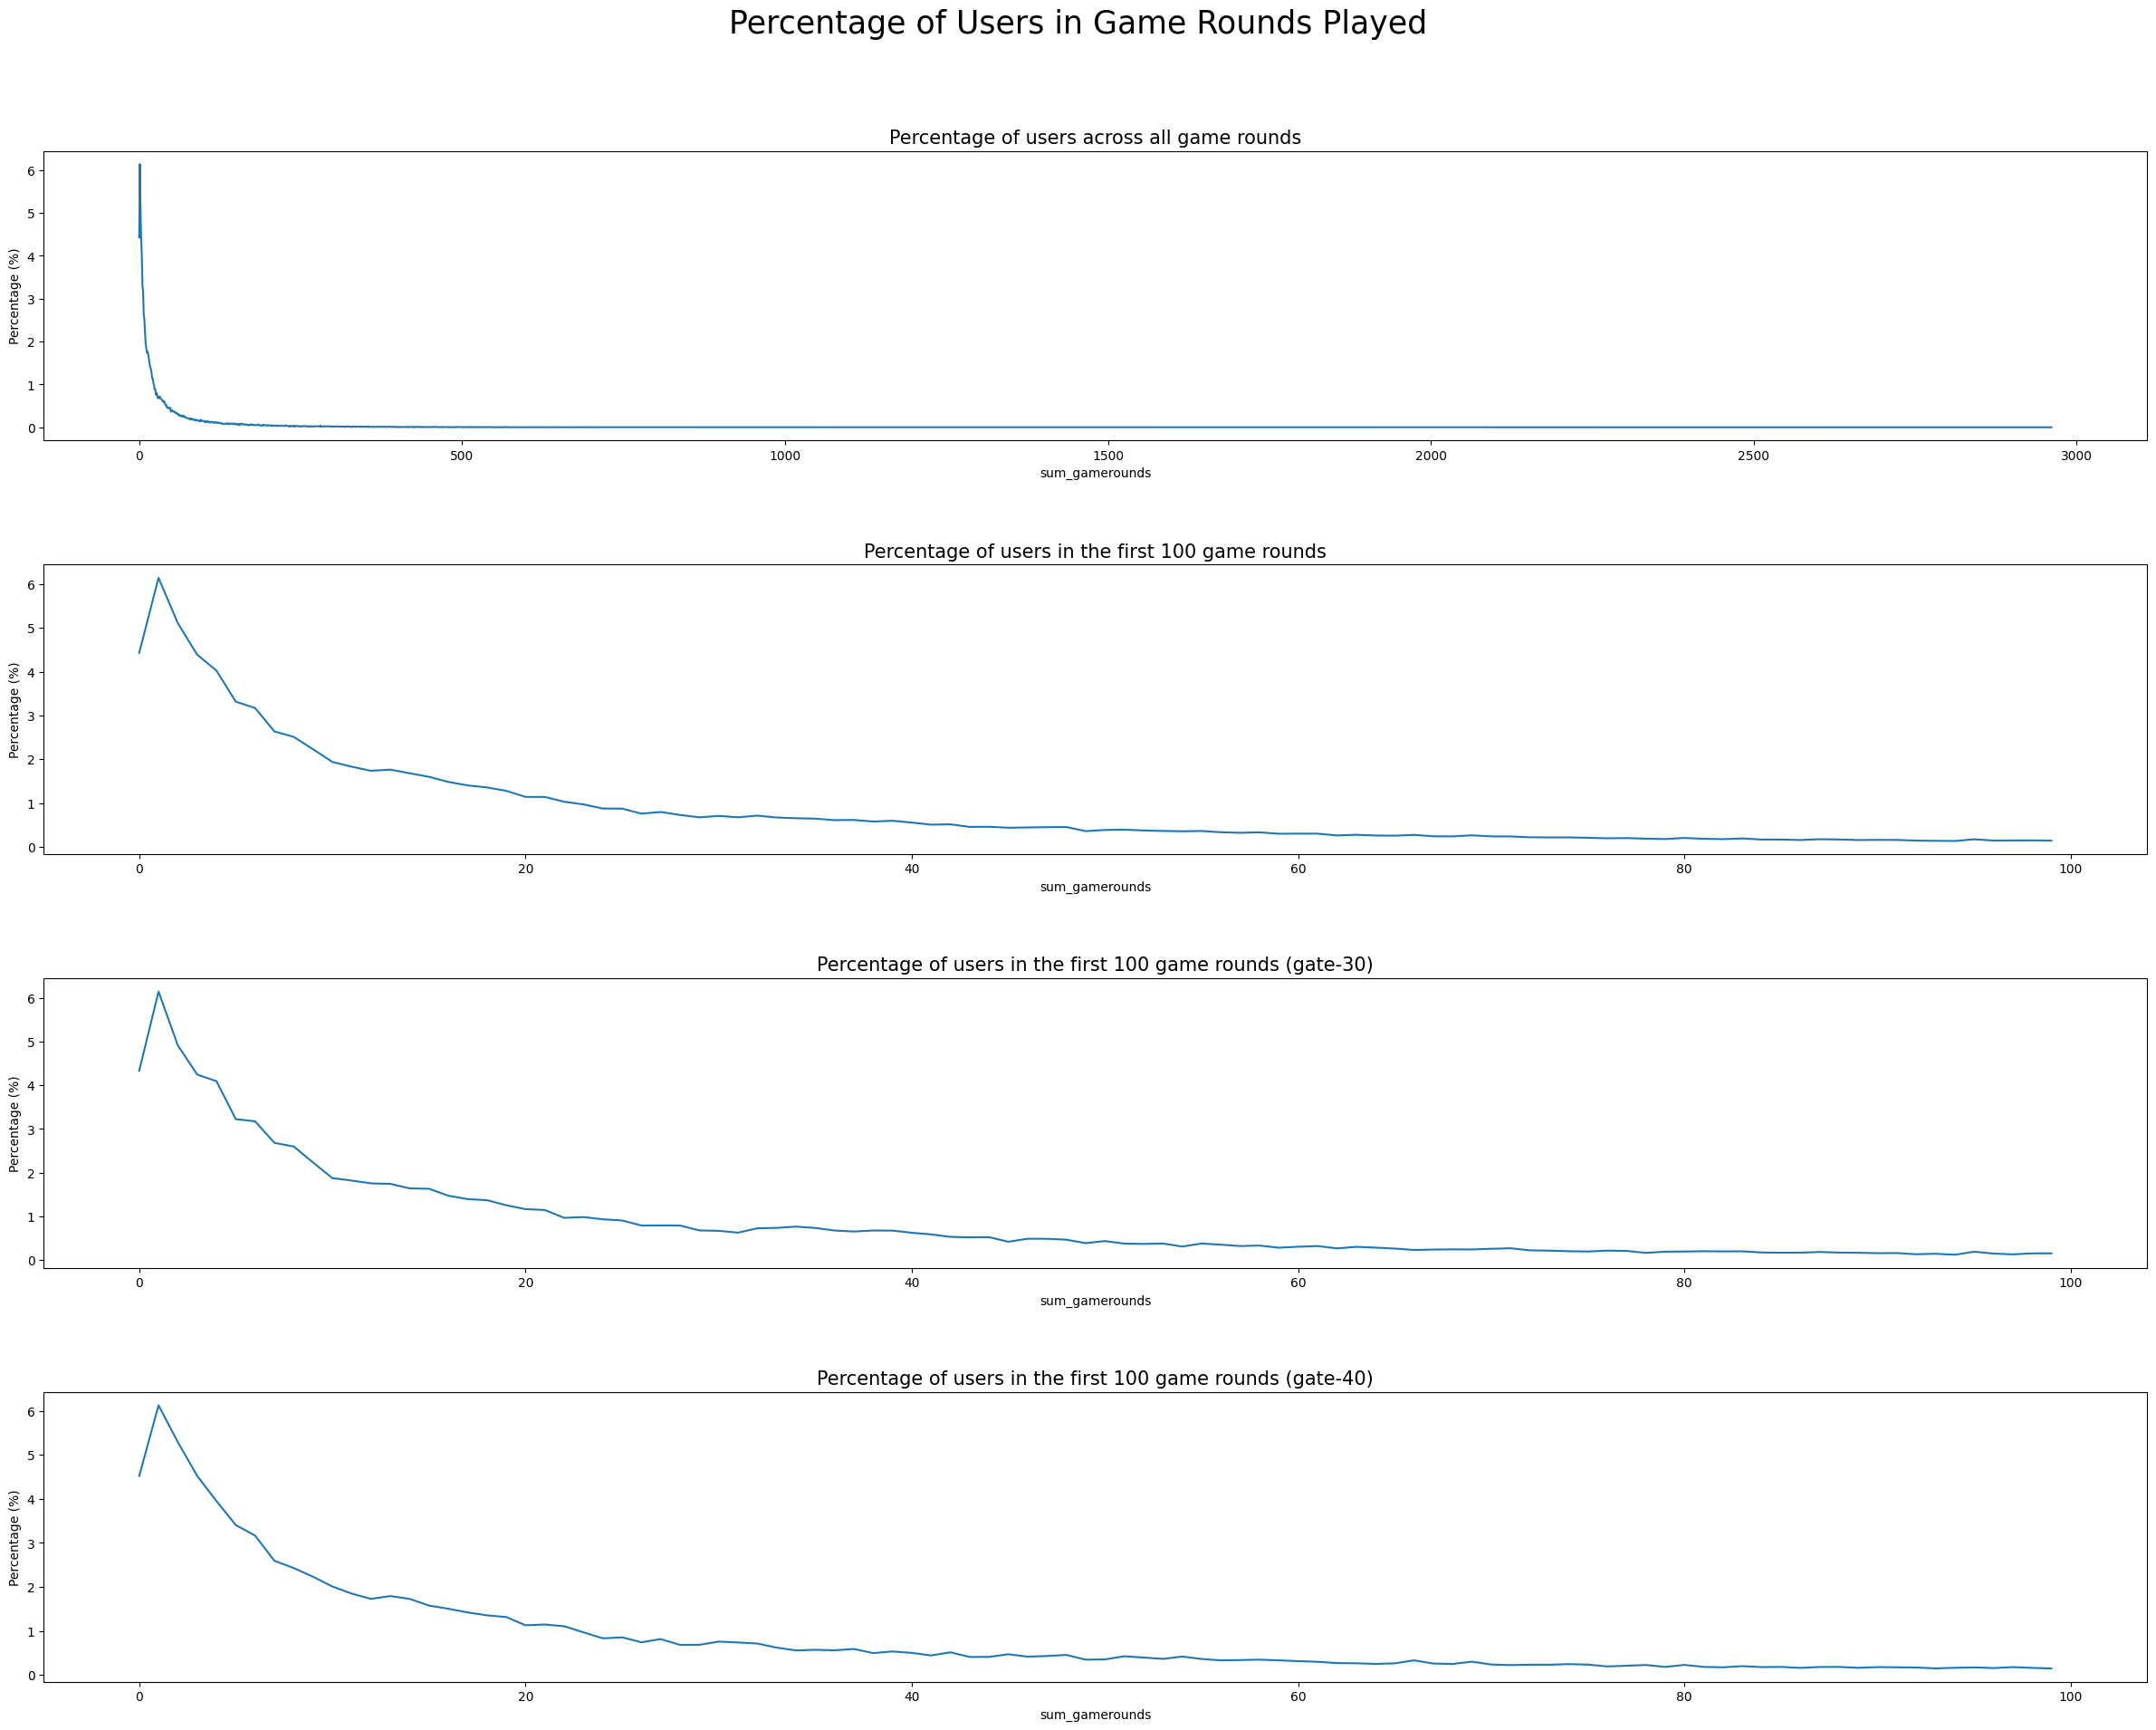

In [95]:
# visual -> most people play less 10 rounds, some people don't play at all (4%)
# it looks like a poisson distribution
# Calculate total user count for percentages
total_users = df.userid.count()
gate_30_users = df[df.version == "gate_30"].userid.count()
gate_40_users = df[df.version == "gate_40"].userid.count()

# Plots: Percentage of users across all game rounds
fig, axes = plt.subplots(4, 1, figsize=(25, 20))
(df.groupby("sum_gamerounds").userid.count() / total_users * 100).plot(ax=axes[0])
(df.groupby("sum_gamerounds").userid.count()[:100] / total_users * 100).plot(ax=axes[1])
(df[df.version == "gate_30"].groupby("sum_gamerounds").userid.count()[:100] / gate_30_users * 100).plot(ax=axes[2])
(df[df.version == "gate_40"].groupby("sum_gamerounds").userid.count()[:100] / gate_40_users * 100).plot(ax=axes[3])

axes[0].set_title("Percentage of users across all game rounds", fontsize=15)
axes[1].set_title("Percentage of users in the first 100 game rounds", fontsize=15)
axes[2].set_title("Percentage of users in the first 100 game rounds (gate-30)", fontsize=15)
axes[3].set_title("Percentage of users in the first 100 game rounds (gate-40)", fontsize=15)

plt.suptitle("Percentage of Users in Game Rounds Played", fontsize=25)
for ax in axes:
    ax.set_ylabel("Percentage (%)")
plt.tight_layout(pad=5)
plt.show()

## minimum sample size ##

In [96]:
def calculate_sample_size(alpha, power, sigma, delta):
    # Get Z-scores for alpha and power
    z_alpha = norm.ppf(1 - alpha / 2)  # two-tailed test
    z_beta = norm.ppf(power)

    # Calculate sample size per group
    n = ((z_alpha + z_beta) ** 2 * 2 * sigma**2) / delta**2

    return np.ceil(n)  # Round up to the next whole number

# Example parameters
alpha = 0.05         # Significance level
power = 0.80         # Desired power
sigma = df["sum_gamerounds"].std() # Estimated standard deviation (in rounds)
delta = 4            # Minimum detectable effect size (in rounds)

# Calculate sample size
sample_size = calculate_sample_size(alpha, power, sigma, delta)
print(f"Required sample size per group: {sample_size}")

Required sample size per group: 10345.0


In [97]:
# sampling based on the validity and minimum size
df["version"] = np.where(df.version == "gate_30", "A", "B")
df_cleaned = df.copy()
df_cleaned = df_cleaned[((df_cleaned['version'] == "A") & (df_cleaned['sum_gamerounds'] >= 30)) |
                        ((df_cleaned['version'] == "B") & (df_cleaned['sum_gamerounds'] >= 40))]

# Get the counts of players per version
count_A = df_cleaned[df_cleaned['version'] == 'A'].shape[0]
count_B = df_cleaned[df_cleaned['version'] == 'B'].shape[0]

# Determine the smaller of the two counts
print("Data points overview:")
print(f"Players in version A: {count_A:02d}")
print(f"Players in version B: {count_B:02d}")
n = min(count_A, count_B, 10345)

# Sample n players from each version
df_A = df_cleaned[df_cleaned['version'] == 'A'].sample(n=n, random_state=42)
df_B = df_cleaned[df_cleaned['version'] == 'B'].sample(n=n, random_state=42)
df_balanced = pd.concat([df_A, df_B])

# Print the shape and group counts for each version in the balanced dataset
print("Balanced Data Shape:", df_balanced.shape)
print("\nPlayers Count per Version (Balanced):")
print(df_balanced.groupby("version")['sum_gamerounds'].count())

# Create a result table showing basic summary statistics for the balanced dataset
result_table = df_balanced.groupby("version")['sum_gamerounds'].agg(
    count='count',
    median='median',
    mean='mean',
    std='std',
    max='max'
).reset_index()

print("\nSummary Table:")
print(result_table)

Data points overview:
Players in version A: 16655
Players in version B: 13827
Balanced Data Shape: (20690, 5)

Players Count per Version (Balanced):
version
A    10345
B    10345
Name: sum_gamerounds, dtype: int64

Summary Table:
  version  count  median        mean         std   max
0       A  10345    71.0  122.046979  137.553978  1906
1       B  10345    91.0  142.700338  150.175510  2294


## AB test ##

In [109]:
def AB_Test(dataframe, group, target):

    # Split A/B
    groupA = dataframe[(dataframe[group] == "A")][target]
    groupB = dataframe[(dataframe[group] == "B")][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    print("Normality:")
    print("shapiro test for group A:" + str(shapiro(groupA)[1]))
    print("shapiro test for group B:" + str(shapiro(groupB)[1]))
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]

    # Result
    test_type = "Parametric" if not ntA and not ntB else "Non-Parametric"
    ab_hypothesis = "Reject H0" if ttest < 0.05 else "Fail to Reject H0"
    comment = "A/B groups are not similar!" if ab_hypothesis == "Reject H0" else "A/B groups are similar!"

    # Print Hypothesis
    print("\nA/B Testing Hypothesis:")
    print("H0: A == B")
    print("H1: A != B")

    print("\nResults:")
    print("Test Type:", test_type)
    print("AB Hypothesis:", ab_hypothesis)
    print("p-value:", round(ttest, 4))
    print("Comment:", comment)

    if not (ntA or ntB):
        homogeneity = "Yes" if not leveneTest else "No"
        print("Homogeneity:", homogeneity)

    # Calculate means and standard deviations for each group
    mean_A, mean_B = np.mean(groupA), np.mean(groupB)
    std_A, std_B = np.std(groupA, ddof=1), np.std(groupB, ddof=1)
    n_A, n_B = len(groupA), len(groupB)
    # Calculate pooled standard deviation
    pooled_std = np.sqrt(((n_A - 1) * std_A**2 + (n_B - 1) * std_B**2) / (n_A + n_B - 2))
    # Calculate Cohen's d
    cohen_d = abs(mean_A - mean_B) / pooled_std

    # Decide the effect size
    if cohen_d < 0.2:
        effect_size = "small"
    elif cohen_d < 0.5:
        effect_size = "moderate"
    else:
        effect_size = "large"
    print("\nEffect Size: " + str(cohen_d.round(5)) + ", which is " + effect_size + ".")

    return

In [110]:
# Apply A/B Testing
AB_Test(dataframe = df_balanced, group = "version", target = "sum_gamerounds")

Normality:
shapiro test for group A:2.525559827604345e-91
shapiro test for group B:7.840097483780142e-92

A/B Testing Hypothesis:
H0: A == B
H1: A != B

Results:
Test Type: Non-Parametric
AB Hypothesis: Reject H0
p-value: 0.0
Comment: A/B groups are not similar!

Effect Size: 0.14342, which is small.
